# <center><u>Avocado Price Forecasting - Modelling Notebook</u></center>

In [19]:
# Data manipulation
from datetime import datetime
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.colors import DivergingNorm
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from itertools import combinations

# preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.preprocessing import OneHotEncoder


# Machine Learning
from sklearn.model_selection import train_test_split

# Classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

# Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

# ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
pd.options.display.float_format = '{:.2f}'.format

np.warnings.filterwarnings('ignore')

In [20]:
df = pd.read_csv('avocado-updated-2020.csv')
df.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.00,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.00,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.00,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.00,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.00,conventional,2015,Baltimore/Washington


In [21]:
df['date']=pd.to_datetime(df['date'])

df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
# monday = 0
df['day of week'] = df['date'].dt.dayofweek
dates = ['year', 'month', 'day', 'day of week']
df[dates]

,year,month,day,day of week
0,2015,1,4,6
1,2015,1,4,6
2,2015,1,4,6
3,2015,1,4,6
4,2015,1,4,6
...,...,...,...,...
33040,2020,11,29,6
33041,2020,11,29,6
33042,2020,11,29,6
33043,2020,11,29,6


- year

    - 2015, 2016, 2017 have almost the same values
    - 2020 is the lowest, the should have ended in the beggining of 2020

- month

    - Shows an ascending pattern.


- day & day of week

    - We can see that the day chart has a repeating trend, and this is because of the day that the data was always recorded: day 6 (Sunday).
    - The data was, therefore, recorded weekly, 'day of week' becomes redundant and we can eliminate it.

In [22]:
df.drop('day of week', axis=1, inplace=True)

### Descriptive analysis conclusions
'type' has to categories and is balanced, could be used as a classifier in model building
'region' has 54 unique values and is perfectly balanced, could be hot encoded for model building
'avg' price shows and pretty normal distribution and looks tentative for target variable for regression model
units sold columns show similar data which is similarly distributed, log formulas could be used to increase model performance
'dates' is evenly distributed till 2018 and shows that the data was recorded on a weekly basis every Sunday

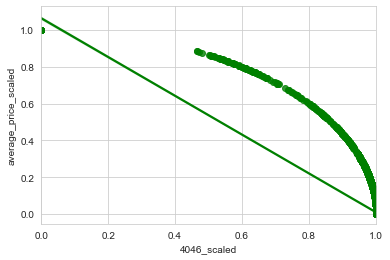

In [5]:
scaler = Normalizer()
scaler.fit(df[['4046', 'average_price']].values)
df['4046_scaled'] = scaler.transform(df[['4046', 'average_price']].values)[:,0]
df['average_price_scaled'] = scaler.transform(df[['4046', 'average_price']].values)[:,1]

sns.regplot(x='4046_scaled', y='average_price_scaled', data=df, color='g')
plt.show()

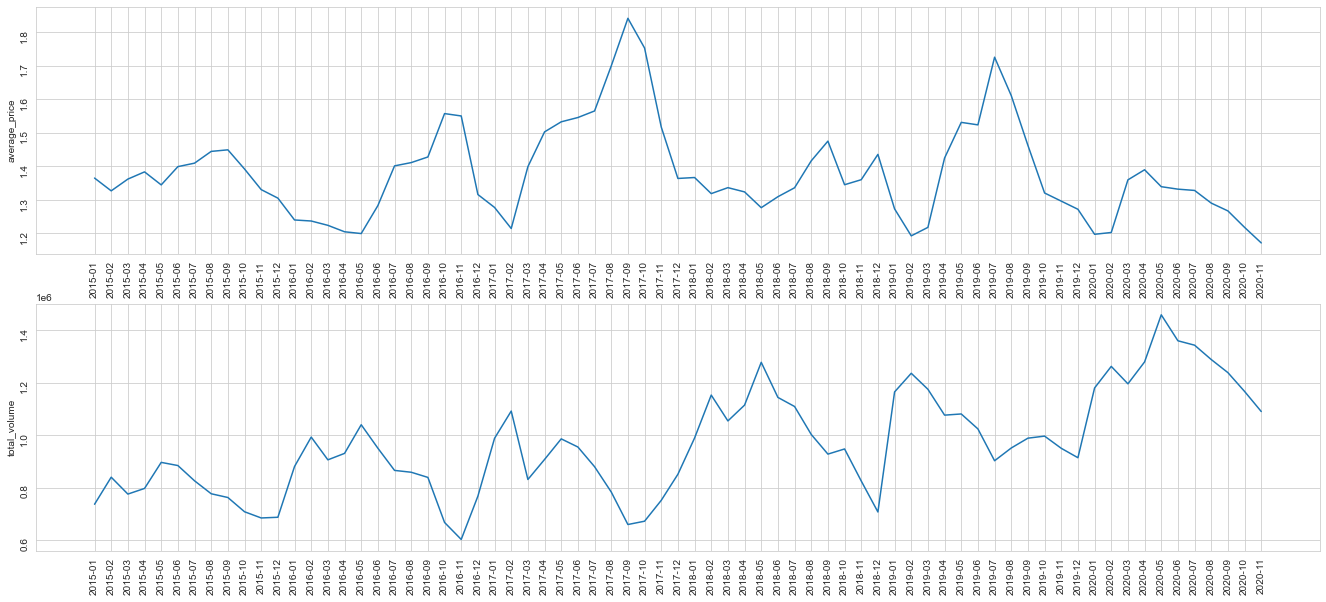

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(23,10))

df['year_month'] = df['date'].dt.to_period('M')
grouped = df.groupby('year_month')[['average_price', 'total_volume']].mean()

ax[0].plot(grouped.index.astype(str), grouped['average_price'])
ax[0].tick_params(labelrotation=90)
ax[0].set_ylabel('average_price')


ax[1].plot(grouped.index.astype(str), grouped['total_volume'])
ax[1].tick_params(labelrotation=90)
ax[1].set_ylabel('total_volume')

plt.show()

- From the graphic we can tell that the, first of all, average price and total volume move in different direction
- Total volume has a pike at the beggining of the year. On the other hand, average price drops at the beggining of the year
- These drops and pikes are a sign of seasonality and that could help in forecasting
- We will dig deeper into these seasonality in further sections

<a id=section12></a>

# Regression Models
  ## Decision Tree Regressor

In [7]:
avo_model = df.drop(['date', '4046_scaled', 'average_price_scaled', 'year_month', 'type', 'geography'], axis=1)
target = avo_model['average_price']
features = avo_model.drop(['average_price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, random_state=0)

In [8]:
tree = DecisionTreeRegressor(max_depth=14, random_state=0).fit(X_train, y_train)
print("Training set score : {:.2f}".format(tree.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(tree.score(X_test, y_test)))

print("\n", "Feature importances:")
feature_importance = pd.DataFrame(list(features.keys()), tree.feature_importances_)
print(feature_importance.sort_index(ascending=False))

Training set score : 0.88
Testing set score: 0.68

 Feature importances:
                 0
0.43          4046
0.11          4225
0.10    total_bags
0.07          year
0.07         month
0.06    large_bags
0.04    small_bags
0.04          4770
0.04  total_volume
0.02   xlarge_bags
0.01           day


## Linear models

In [9]:
lr = LinearRegression().fit(X_train, y_train)
print('Linear Regression')
print("Training set score : {:.2f}".format(lr.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(lr.score(X_test, y_test)))

print('\nRidge')
ridge = Ridge().fit(X_train, y_train)
print("Training set score : {:.2f}".format(ridge.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(ridge.score(X_test, y_test)))

print('\nLasso')
lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Linear Regression
Training set score : 0.07
Testing set score: 0.06

Ridge
Training set score : 0.07
Testing set score: 0.06

Lasso
Training set score: 0.05
Testing set score: 0.04
Number of features used: 8


Our model performs quite bad with the given features. From previous sections, we know that a better way to represent the volume data is applying a log formula or a normalizer. let's try both methods and see if we can get a better prediciton.

In [10]:
avo_model = df.drop(['date', '4046_scaled', 'average_price_scaled', 'year_month', 'type', 'geography'], axis=1)
target = avo_model['average_price']
features = avo_model.drop(['average_price'], axis=1)

features.iloc[:,0:7] = np.log(features.iloc[:,0:7] + 1)
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, random_state=0)

lr = LinearRegression().fit(X_train, y_train)
print('Linear Regression')
print("Training set score : {:.2f}".format(lr.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(lr.score(X_test, y_test)))

print('\nRidge')
ridge = Ridge().fit(X_train, y_train)
print("Training set score : {:.2f}".format(ridge.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(ridge.score(X_test, y_test)))

print('\nLasso')
lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Linear Regression
Training set score : 0.43
Testing set score: 0.42

Ridge
Training set score : 0.43
Testing set score: 0.42

Lasso
Training set score: 0.01
Testing set score: 0.01
Number of features used: 1


This time, it performs better. Now let's add some dummu variables. 

In [11]:
avo_model = df.drop(['date', '4046_scaled', 'average_price_scaled', 'year_month'], axis=1)
avo_model = pd.get_dummies(avo_model)

target = avo_model['average_price']
features = avo_model.drop(['average_price'], axis=1)

features.iloc[:,0:7] = np.log(features.iloc[:,0:7] + 1)
X_train, X_test, y_train, y_test = train_test_split(features.values, target.values, random_state=0)

lr = LinearRegression().fit(X_train, y_train)
print('Linear Regression')
print("Training set score : {:.2f}".format(lr.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(lr.score(X_test, y_test)))

print('\nRidge')
ridge = Ridge().fit(X_train, y_train)
print("Training set score : {:.2f}".format(ridge.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(ridge.score(X_test, y_test)))

print('\nLasso')
lasso = Lasso().fit(X_train, y_train)
print("Training set score: {:.2f}".format(lasso.score(X_train, y_train)))
print("Testing set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso.coef_ != 0))

Linear Regression
Training set score : 0.66
Testing set score: 0.65

Ridge
Training set score : 0.66
Testing set score: 0.65

Lasso
Training set score: 0.01
Testing set score: 0.01
Number of features used: 1


We just got a 0.26 better testing score than the descision tree with a way lower training score, which is a good sign that we are not over fitting.
With some feature engineering we were able to make the linear models better than the decision tree, except for Lasso where we never were able to increase the test score more than 1

<a id=section12></a>

<a id=section12></a>

### Functions for analysis

In [23]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [24]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

<a id=section12></a>

<a id=section12></a>

## PREPROCESSING

### Dropping the uneccessary columns 
    - CONVERTING DATES TO DATETIME AND SETTING IT AS INDEX
    - RESAMPLE [GROUPBY] THE DATA 

In [25]:
df = df.drop(columns = ['total_volume','total_bags','year','4046','4225','4770','small_bags','large_bags','xlarge_bags', 'month', 'day'])

df = df.set_index('date')
df = df.resample('W').sum()
df.head()

,average_price
date,
2015-01-04,140.54
2015-01-11,148.03
2015-01-18,150.24
2015-01-25,150.89
2015-02-01,134.68


<a id=section12></a>

### Timeseries analysis

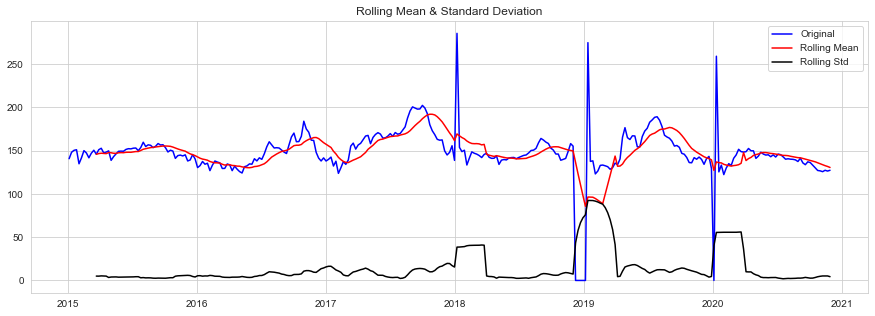

Results of Dickey-Fuller Test:
Test Statistic                 -3.79
p-value                         0.00
#Lags Used                      6.00
Number of Observations Used   302.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [26]:
test_stationarity(df['average_price'])

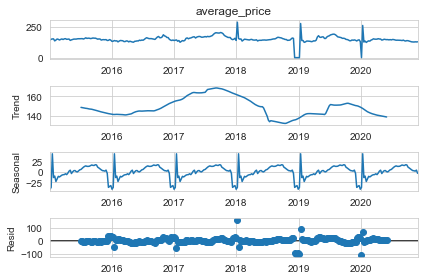

In [27]:
dec = sm.tsa.seasonal_decompose(df['average_price'],period = 52).plot()
plt.show()

- #### The data has a trend and a seasonality 
- #### The data has a slightly increasing trend 
- #### The data has an yearly seasonality pattern 

## DIFFERENCING

- #### 1st DIFFERENCING TO ELIMINATE THE TREND 

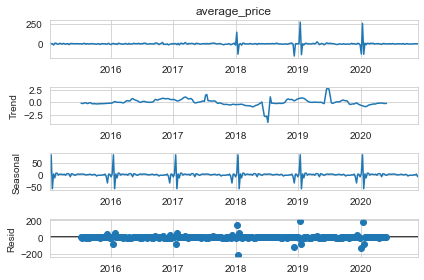

In [28]:
data_diff = df['average_price'].diff()
data_diff = data_diff.dropna()
dec = sm.tsa.seasonal_decompose(data_diff,period = 52).plot()
plt.show()

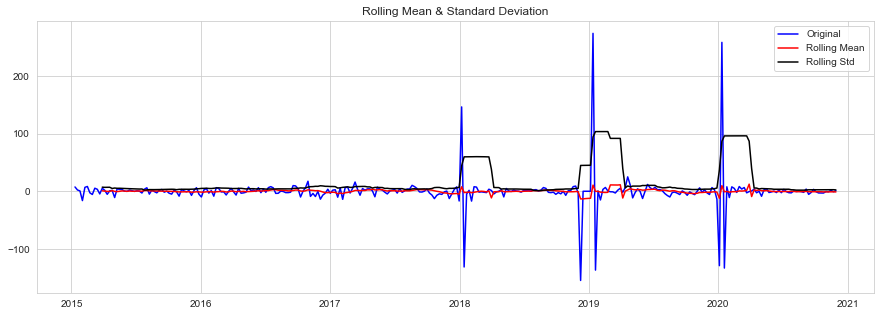

Results of Dickey-Fuller Test:
Test Statistic                -11.67
p-value                         0.00
#Lags Used                      5.00
Number of Observations Used   302.00
Critical Value (1%)            -3.45
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [29]:
test_stationarity(data_diff)

- #### DICKEY-FULLER Теst tells us that our data is stationary
- #### Determination if the data is stationary:

    - 1. P-VALUE < 0.05
    - 2. TEST STATISTIC < CRITICAL VALUE

<a id=section12></a>

# ARIMA

-  The predictions of the ARIMA model might not be good as we have seasonal data 
-  We have not considered the seasonal pattern here
-  p = PARTIAL AUTOCORRELATION = 0 -> plot shows insignificant lags
-  d = DIFFERENCING = 0 -> differencing done one at a time 
-  q = AUTOCORRELATION = 0 -> plot shows no insignificant lags

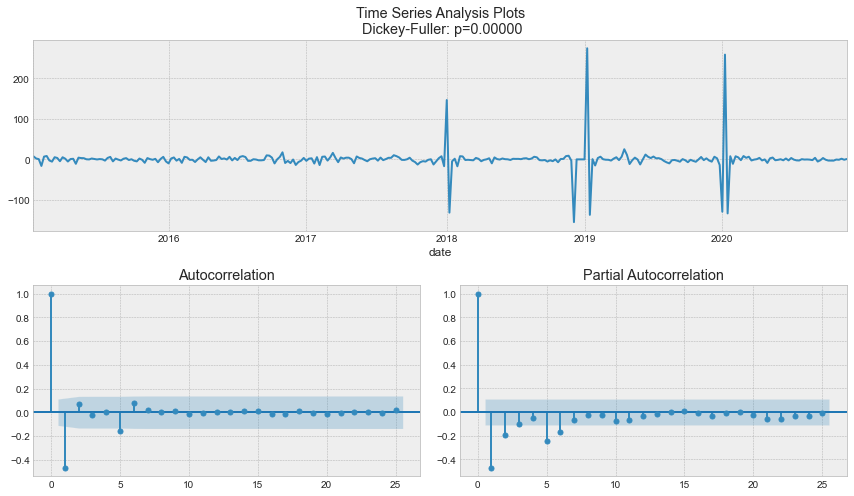

In [30]:
tsplot(data_diff)

In [31]:
model = ARIMA(df['average_price'],order = (0,1,0))
model_fit = model.fit()
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:        D.average_price   No. Observations:                  308
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1479.228
Method:                           css   S.D. of innovations             29.481
Date:                Mon, 10 May 2021   AIC                           2962.455
Time:                        23:33:27   BIC                           2969.915
Sample:                    01-11-2015   HQIC                          2965.438
                         - 11-29-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0434      1.680     -0.026      0.979      -3.336       3.249


<AxesSubplot:xlabel='date'>

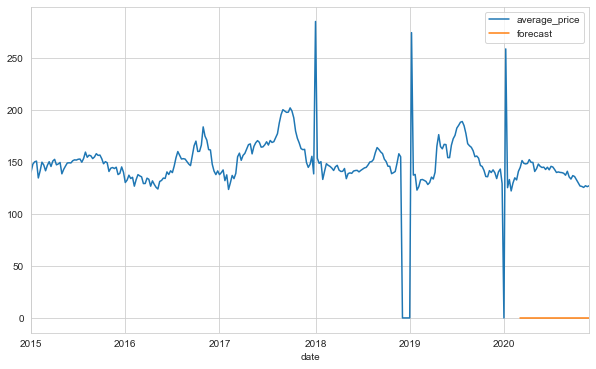

In [32]:
df['forecast'] = model_fit.predict(start = 270,end = 330,dynamic = True)
df[['average_price','forecast']].plot(figsize = (10,6))

In [33]:
exp = [df.iloc[i,0] for i in range(270,len(df))]
pred = [df.iloc[i,1] for i in range(270,len(df))]
data = df.drop(columns = 'forecast')
error = mean_absolute_error(exp,pred)
error

140.27930652680652

- The model outputs poor predictions 
- Mean absolute error value also has a high value 
- -->Therefore, we reject this model and move towards seasonal S/ARIMA 

<a id=section12></a>

<a id=section12></a>

# SARIMAX

- Here, we are working on weekly data and our seasonal period is consisting of one year  
- For our data, S = 52 weeks, so 52 entries of our dataframe 
- Hence, we differenciate by 52

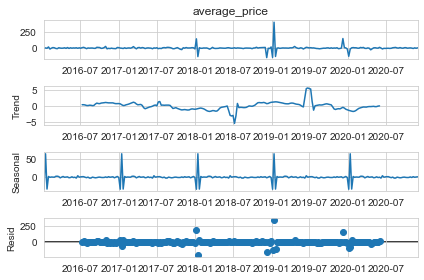

In [34]:
data_diff_seas = data_diff.diff(52)
data_diff_seas = data_diff_seas.dropna()
dec = sm.tsa.seasonal_decompose(data_diff_seas,period = 52).plot()
plt.show()

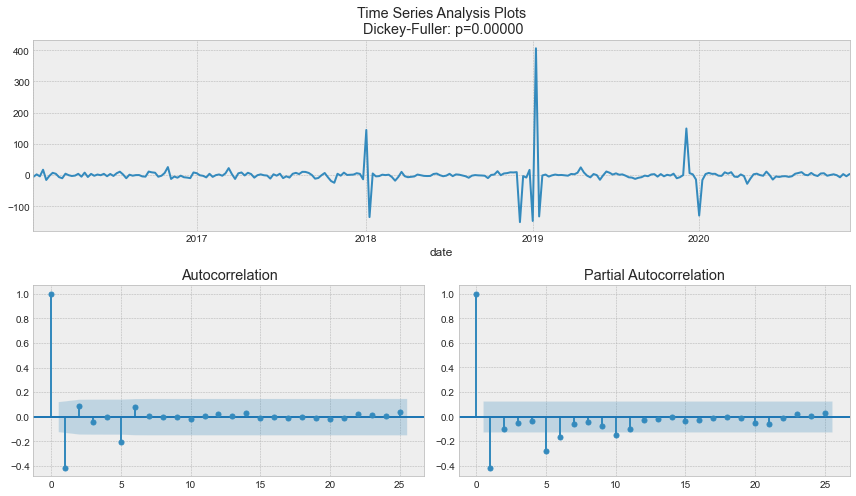

In [35]:
tsplot(data_diff_seas)

<a id=section12></a>

# Seasonal order

#### SIMILAR TO ARIMA ORDER
-  P ->(0-2) 
-  D ->1
-  Q ->(0-2)
Select order having the least AIC model value

In [36]:
model = sm.tsa.statespace.SARIMAX(df['average_price'],order = (0,1,0),seasonal_order = (1,1,0,52))
results = model.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      average_price   No. Observations:                  309
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1264.211
Date:                            Mon, 10 May 2021   AIC                           2532.422
Time:                                    23:33:46   BIC                           2539.512
Sample:                                01-04-2015   HQIC                          2535.273
                                     - 11-29-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L52      -0.2738      0.019    -14.135      0.000      -0.312      -0.236
sigma2      1122.1336     21.423   

<AxesSubplot:xlabel='date'>

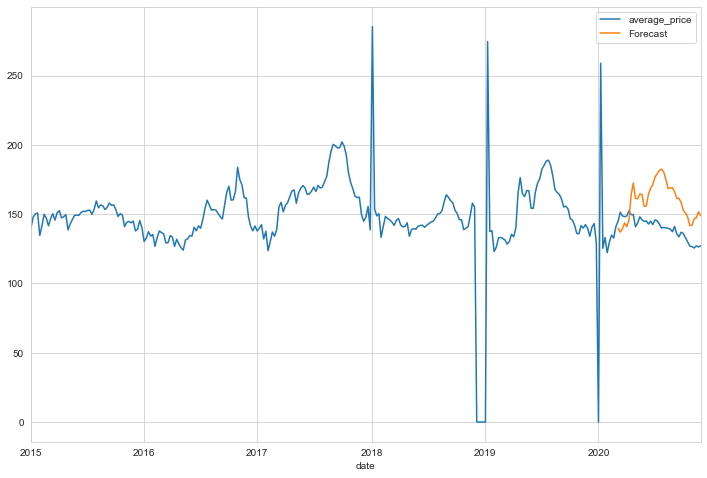

In [37]:
df['Forecast'] = results.predict(start = 270,end = 329,dynamic = True)
df[['average_price','Forecast']].plot(figsize = (12,8))

In [38]:
exp = [df.iloc[i,0] for i in range(270,len(df))]
pred = [df.iloc[i,1] for i in range(270,len(df))]

error = mean_absolute_error(exp,pred)
error

140.27930652680652

# Forecasting

In [39]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(weeks = x)for x in range(0,52)]

In [40]:
df = pd.DataFrame(index = future_dates[1:],columns = data.columns)

<AxesSubplot:>

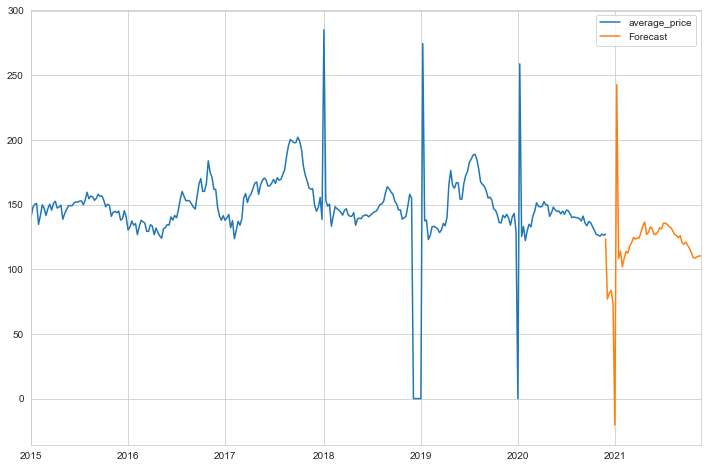

In [41]:
forecast = pd.concat([data,df])
forecast['Forecast'] = results.predict(start = 308,end = 370,dynamic = True)
forecast[['average_price','Forecast']].plot(figsize = (12,8))